In [3]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import time
import os

In [4]:
class Gate1(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.linear = nn.Linear(in_dim, out_dim)
    
    def forward(self, x):
        return torch.tanh(self.linear(x))

In [5]:
class Gate2(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.linear = nn.Linear(in_dim, out_dim)
    
    def forward(self, x):
        return torch.tanh(self.linear(x))

In [6]:
class Network(nn.Module):
    def __init__(self, num_input=2, layers=[64, 64, 64], num_output=3):
        super().__init__()
        self.input_layer = nn.Linear(num_input, layers[0])
        self.z_layers = nn.ModuleList()
        self.gate1 = Gate1(num_input, layers[0])
        self.gate2 = Gate2(num_input, layers[0])
        for i in range(len(layers)-1):
            self.z_layers.append(nn.Linear(layers[i], layers[i+1]))
        self.output_layer = nn.Linear(layers[-1], num_output)

    def forward(self, x):
        U = self.gate1(x)
        V = self.gate2(x)
        h = torch.tanh(self.input_layer(x))
        for z_layer in self.z_layers:
            Z = torch.tanh(z_layer(h))
            h = (1 - Z) * U + Z * V
        return self.output_layer(h)

In [7]:
class Pinns:
    def __init__(self):
        # Transfer to GPU if it is possible
        self.device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
        self.network = Network().to(self.device)

        # Assumptions
        self.rho=1.0
        self.nu=0.01
        self.u0=1.0

        # Domain_Definition
        dx=0.01
        dy=0.01
        self.x=torch.arange(0,1+dx,dx)
        self.y=torch.arange(0,1+dy,dy)
        self.X = torch.stack(torch.meshgrid(self.x,self.y)).reshape(2,-1).T

        # Transfer tensor to GPU
        self.X = self.X.to(self.device)

        # Error criterion Definition
        self.criterion = nn.MSELoss()

        # Optimizer setting
        self.adam = torch.optim.Adam(self.network.parameters())
        # , lr=1e-4
        # Limited-memory Broyden-Fletcher-Goldfarb-Shanno (L-BFGS)
        self.optimizer = torch.optim.LBFGS(
        self.network.parameters(),
            lr=1.0,
            max_iter = 1000,
            max_eval = 1000,
            history_size = 50,
            tolerance_grad = 1e-7,
            tolerance_change = 1.0* np.finfo(float).eps,
            line_search_fn ="strong_wolfe"
        )
    def loss_f(self):
        # Restart Optimizer
        self.adam.zero_grad()
        self.optimizer.zero_grad()

        # Network prediction
        self.uvp_P = self.network(self.X)
        self.u_P = self.uvp_P[:, 0].reshape(len(self.x), len(self.y))
        self.v_P = self.uvp_P[:, 1].reshape(len(self.x), len(self.y))
        self.p_P = self.uvp_P[:, 2].reshape(len(self.x), len(self.y))

        # Apply hard boundary conditions
        self.u_P[0, :], self.u_P[-1, :], self.u_P[:, 0], self.u_P[:, -1] = 0.0, 0.0, 0.0, self.u0
        self.v_P[0, :], self.v_P[-1, :], self.v_P[:, 0], self.v_P[:, -1] = 0.0, 0.0, 0.0, 0.0

        dx = self.x[1] - self.x[0]
        dy = self.y[1] - self.y[0]
        
        #Second order diff
        def central_diff_x(arr):
            res = torch.zeros_like(arr)
            res[1:-1, :] = (arr[2:, :] - arr[:-2, :]) / (2 * dx)
            return res

        def central_diff_y(arr):
            res = torch.zeros_like(arr)
            res[:, 1:-1] = (arr[:, 2:] - arr[:, :-2]) / (2 * dy)
            return res

        def second_diff_x(arr):
            res = torch.zeros_like(arr)
            res[1:-1, :] = (arr[2:, :] - 2 * arr[1:-1, :] + arr[:-2, :]) / (dx ** 2)
            return res

        def second_diff_y(arr):
            res = torch.zeros_like(arr)
            res[:, 1:-1] = (arr[:, 2:] - 2 * arr[:, 1:-1] + arr[:, :-2]) / (dy ** 2)
            return res
        du_dx = central_diff_x(self.u_P)
        du_dy = central_diff_y(self.u_P)
        du_dxx = second_diff_x(self.u_P)
        du_dyy = second_diff_y(self.u_P)

        dv_dx = central_diff_x(self.v_P)
        dv_dy = central_diff_y(self.v_P)
        dv_dxx = second_diff_x(self.v_P)
        dv_dyy = second_diff_y(self.v_P)
    
        dp_dx = central_diff_x(self.p_P)
        dp_dy = central_diff_y(self.p_P)

        # Extract interior points
        slice_in = slice(1, -1)
        u_int = self.u_P[slice_in, slice_in]
        v_int = self.v_P[slice_in, slice_in]
        du_dx_int = du_dx[slice_in, slice_in]
        du_dy_int = du_dy[slice_in, slice_in]
        du_dxx_int = du_dxx[slice_in, slice_in]
        du_dyy_int = du_dyy[slice_in, slice_in]
        dv_dx_int = dv_dx[slice_in, slice_in]
        dv_dy_int = dv_dy[slice_in, slice_in]
        dv_dxx_int = dv_dxx[slice_in, slice_in]
        dv_dyy_int = dv_dyy[slice_in, slice_in]
        dp_dx_int = dp_dx[slice_in, slice_in]
        dp_dy_int = dp_dy[slice_in, slice_in]

        # Compute PDE residuals
        con_equ = du_dx_int + dv_dy_int
        u_eqn = u_int * du_dx_int + v_int * du_dy_int + dp_dx_int / self.rho - self.nu * (du_dxx_int + du_dyy_int)
        v_eqn = u_int * dv_dx_int + v_int * dv_dy_int + dp_dy_int / self.rho - self.nu * (dv_dxx_int + dv_dyy_int)

        # Calculate loss
        self.loss = self.criterion(con_equ.reshape(-1), torch.zeros_like(con_equ).reshape(-1)) + \
                    self.criterion(u_eqn.reshape(-1), torch.zeros_like(u_eqn).reshape(-1)) + \
                    self.criterion(v_eqn.reshape(-1), torch.zeros_like(v_eqn).reshape(-1))

        self.loss.backward()
        return self.loss
    def train(self, num_epochs=1):
        self.network.train()
        for i in range(num_epochs):
            loss = self.loss_f()
            if i % 10 == 0:
                print(f"Iteration {i}, Loss: {self.loss.item():.6f}")
            self.adam.step(self.loss_f)
        self.optimizer.step(self.loss_f)
    def plot(self):
        import os
        os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
        self.network.eval()
        with torch.no_grad():
            self.u = self.uvp_P[:,0].reshape(len(self.x), len(self.y)).cpu().numpy().T
            self.v = self.uvp_P[:,1].reshape(len(self.x), len(self.y)).cpu().numpy().T
            self.p = self.uvp_P[:,2].reshape(len(self.x), len(self.y)).cpu().numpy().T
        plt.figure(figsize=(10, 8))
        plt.subplot(2, 2, 1)
        contour1 = plt.contourf(self.x.detach().cpu().numpy(), self.y.detach().cpu().numpy(), self.u, levels=50, cmap="jet")
        plt.colorbar(contour1)
        plt.xlabel("X")
        plt.ylabel("Y")
        plt.title("u")
        plt.subplot(2, 2, 2)
        contour2 = plt.contourf(self.x.detach().cpu().numpy(), self.y.detach().cpu().numpy(), self.v, levels=50, cmap="jet")
        plt.colorbar(contour2)
        plt.xlabel("X")
        plt.ylabel("Y")
        plt.title("v")
        plt.subplot(2, 2, 3)
        contour3 = plt.contourf(self.x.detach().cpu().numpy(), self.y.detach().cpu().numpy(), self.p, levels=50, cmap="jet")
        plt.colorbar(contour3)
        plt.xlabel("X")
        plt.ylabel("Y")
        plt.title("pressure")
        plt.figure(figsize=(8, 8))
        # plt.subplot(2, 2, 4)
        # contour4 = plt.streamplot(self.x.detach().cpu().numpy(), self.y.detach().cpu().numpy(), self.u, self.v, color=self.u, linewidth=2, cmap='autumn')
        # plt.xlabel("X")
        # plt.ylabel("Y")
        # plt.title("streamline")
        # plt.tight_layout()
        # plt.show()

In [8]:
net = Pinns()
# net.network.load_state_dict(torch.load(r'/home/hossein_vasheghani/modelFF_6.pth'))
net.train(num_epochs=10000)
net.plot()

/home/hossein_vasheghani/.conda/envs/hossein_vasheghani/lib/python3.12/site-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1729647378361/work/aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Iteration 0, Loss: 168.083740
Iteration 10, Loss: 51.489727
Iteration 20, Loss: 32.828045
Iteration 30, Loss: 31.297983
Iteration 40, Loss: 26.807623
Iteration 50, Loss: 23.406349
Iteration 60, Loss: 20.371523
Iteration 70, Loss: 17.913111
Iteration 80, Loss: 16.093700
Iteration 90, Loss: 14.911425
Iteration 100, Loss: 14.116861
Iteration 110, Loss: 13.479482
Iteration 120, Loss: 12.887560
Iteration 130, Loss: 12.331938
Iteration 140, Loss: 11.822507
Iteration 150, Loss: 11.359004
Iteration 160, Loss: 10.936189
Iteration 170, Loss: 10.548222
Iteration 180, Loss: 10.189373
Iteration 190, Loss: 9.854622
Iteration 200, Loss: 9.540097
Iteration 210, Loss: 9.242882
Iteration 220, Loss: 8.960892
Iteration 230, Loss: 8.692736
Iteration 240, Loss: 8.437438
Iteration 250, Loss: 8.194116
Iteration 260, Loss: 7.961657
Iteration 270, Loss: 7.738594
Iteration 280, Loss: 7.523251
Iteration 290, Loss: 7.314078
Iteration 300, Loss: 7.109998
Iteration 310, Loss: 6.910522


KeyboardInterrupt: 

In [14]:
torch.save(net.network.state_dict(), r'/home/hossein_vasheghani/modelFF_6.pth')

In [10]:
# Given validation data for R=1000
x_validation = np.array([1, 8, 9, 10, 14, 23, 37, 59, 65, 80, 95, 110, 123, 124, 125, 126, 129])/129
u_validation2 = np.array([0, -0.18109, -0.20196, -0.22220, -0.29730, -0.38289, -0.27805, -0.10648,
                          -0.06080, 0.05702, 0.18719, 0.33304, 0.46604, 0.51117, 0.57492, 0.65928, 1])

y_validation = np.array([1, 9, 10, 11, 13, 21, 30, 31, 65, 104, 111, 117, 122, 123, 124, 125, 129])/129
v_validation2 = np.array([0, 0.27485, 0.29012, 0.30353, 0.32627, 0.37095, 0.33075, 0.32235, 0.02526,
                          -0.31966, -0.42665, -0.51550, -0.39188, -0.33714, -0.27669, -0.21388, 0])

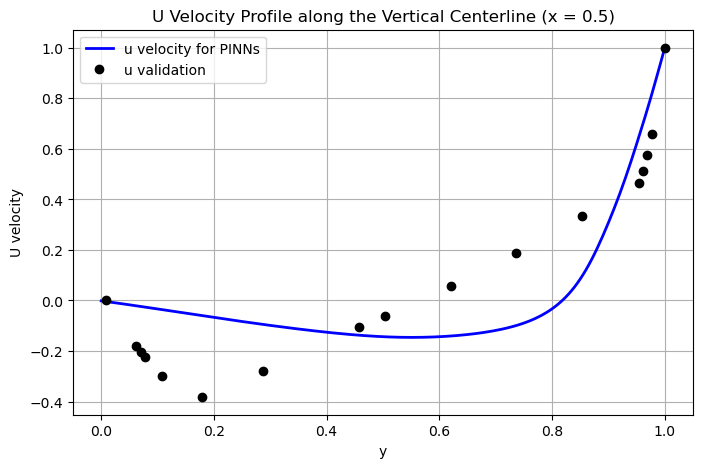

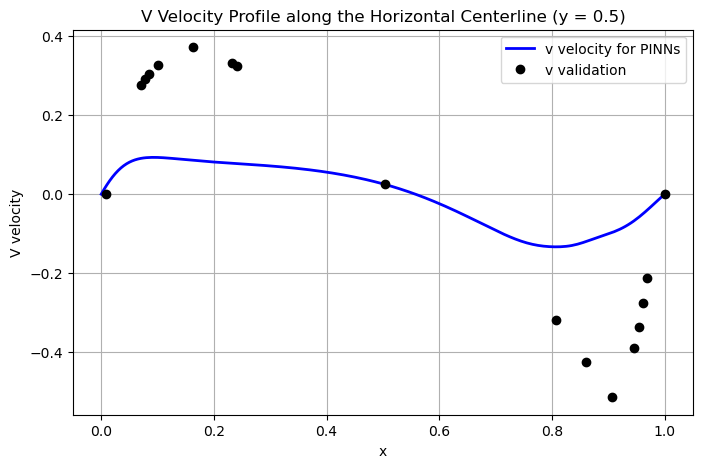

In [11]:
with torch.no_grad():
    uvp_pred = net.network(net.X).reshape(len(net.x), len(net.y), 3)

u = uvp_pred[:, :, 0].detach().cpu().numpy()
v = uvp_pred[:, :, 1].detach().cpu().numpy()

# Plot u velocity along vertical centerline (x = 0.5)
plt.figure(figsize=(8, 5))
center_idx_x = len(net.x) // 2
plt.plot(net.y.cpu(), u[center_idx_x, :], 'b-', linewidth=2, label='u velocity for PINNs')
plt.plot(x_validation, u_validation2, 'ko', label="u validation", markersize=6, linewidth=2)
plt.xlabel("y")
plt.ylabel("U velocity")
plt.title("U Velocity Profile along the Vertical Centerline (x = 0.5)")
plt.legend()
plt.grid(True)
plt.show()

# Plot v velocity along horizontal centerline (y = 0.5)
plt.figure(figsize=(8, 5))
center_idx_y = len(net.y) // 2
plt.plot(net.x.cpu(), v[:, center_idx_y], 'b-', linewidth=2, label='v velocity for PINNs')
plt.plot(y_validation, v_validation2, 'ko', label="v validation", markersize=6, linewidth=2)
plt.xlabel("x")
plt.ylabel("V velocity")
plt.title("V Velocity Profile along the Horizontal Centerline (y = 0.5)")
plt.legend()
plt.grid(True)
plt.show()